<a href="https://colab.research.google.com/github/ILoveCoder999/FederatedLearning/blob/master/centralizedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# import module
import sys
sys.path.append('/content/drive/MyDrive')
from preprocessing import FederatedDataBuilder

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms

# Assuming FederatedDataBuilder is defined in the previous step
# from task_3_1 import FederatedDataBuilder

# ---------------------------------------------------------
# 1. Model Definition: DINO ViT-S/16
# ---------------------------------------------------------
class DINOCIFAR100(nn.Module):
    def __init__(self, num_classes=100, freeze_backbone=False):
        super(DINOCIFAR100, self).__init__()
        # Use the pretrained model architecture DINO ViT-S/16
        # Loading from torch hub
        print("Downloading/Loading DINO ViT-S/16...")
        self.backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

        # DINO ViT-S/16 output embedding dimension is 384
        self.embed_dim = 384

        # Add a classification head for CIFAR-100
        self.head = nn.Linear(self.embed_dim, num_classes)

        # Option to freeze backbone (Linear Probing) or Fine-tune (Standard)
        # The project implies fine-tuning to study parameter sensitivity
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        # DINO forward pass returns the CLS token features
        features = self.backbone(x)
        output = self.head(features)
        return output

# ---------------------------------------------------------
# 2. Helper Functions: Train & Evaluate
# ---------------------------------------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Standard training loop for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm used for progress bar visualization
    for inputs, targets in tqdm(loader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    """
    Standard evaluation loop for validation/test sets.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# ---------------------------------------------------------
# 3. Main Experiment: Centralized Baseline
# ---------------------------------------------------------
def run_centralized_baseline():
    # Centralized baseline
    # Search for best hyperparameters
    BATCH_SIZE = 64         # Adjust based on Colab GPU memory
    EPOCHS = 20             # "How many epochs do you need?" -> Monitor convergence
    LR = 0.001              # Initial learning rate (tune this using Val set)
    MOMENTUM = 0.9          # SGDM Momentum
    WEIGHT_DECAY = 1e-4     # Standard regularization

    # Check for GPU
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # 1. Prepare Data
    # Initialize the builder from Task 3.1
    # Split original dataset to have a validation set
    data_builder = FederatedDataBuilder(val_split_ratio=0.1)

    # Note: ViT usually performs better with 224x224 images.
    # If accuracy is very low, consider adding transforms.Resize(224) in the DataBuilder.

    train_loader = torch.utils.data.DataLoader(
        data_builder.train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        data_builder.val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        data_builder.test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
    )

    # 2. Initialize Model
    model = DINOCIFAR100(num_classes=100).to(DEVICE)

    # 3. Optimizer & Loss
    # "Train your models on CIFAR-100 using the SGDM optimizer"
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    # 4. Scheduler
    # "As a learning rate scheduler, we suggest you use the cosine annealing scheduler"
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # 5. Training Loop
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"Starting centralized training for {EPOCHS} epochs...")
    for epoch in range(EPOCHS):

        # Train
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)

        # Validate Used for hyperparameter tuning
        v_loss, v_acc = evaluate(model, val_loader, criterion, DEVICE)

        # Step Scheduler
        scheduler.step()

        # Logging
        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {t_loss:.4f} Acc: {t_acc:.2f}% | Val Loss: {v_loss:.4f} Acc: {v_acc:.2f}%")

    # 6. Final Test Report test loss and test accuracy
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
    print(f"\nFinal Test Set Performance -> Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")

    # 7. Plotting Report the plots
    plot_results(history)

def plot_results(history):
    """
    Helper function to plot loss and accuracy curves.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



Using device: cuda


100%|██████████| 169M/169M [00:03<00:00, 44.0MB/s]


Downloading/Loading DINO ViT-S/16...
Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 251MB/s]


Starting centralized training for 20 epochs...


Epoch 1/20 | Train Loss: 4.2237 Acc: 7.29% | Val Loss: 3.7528 Acc: 13.26%


Epoch 2/20 | Train Loss: 3.3819 Acc: 19.50% | Val Loss: 3.1601 Acc: 23.62%


Epoch 3/20 | Train Loss: 2.7260 Acc: 31.70% | Val Loss: 2.7006 Acc: 32.20%


Epoch 4/20 | Train Loss: 2.1714 Acc: 43.41% | Val Loss: 2.4992 Acc: 36.46%


Epoch 5/20 | Train Loss: 1.6727 Acc: 54.28% | Val Loss: 2.5097 Acc: 38.24%


Epoch 6/20 | Train Loss: 1.1956 Acc: 65.86% | Val Loss: 2.7579 Acc: 38.18%


Epoch 7/20 | Train Loss: 0.7443 Acc: 77.70% | Val Loss: 3.0467 Acc: 38.14%


Epoch 8/20 | Train Loss: 0.4113 Acc: 87.12% | Val Loss: 3.3835 Acc: 37.76%


Epoch 9/20 | Train Loss: 0.1522 Acc: 95.32% | Val Loss: 3.5869 Acc: 40.26%


Epoch 10/20 | Train Loss: 0.0371 Acc: 99.16% | Val Loss: 3.6014 Acc: 42.56%


Epoch 11/20 | Train Loss: 0.0092 Acc: 99.89% | Val Loss: 3.5661 Acc: 43.16%


Epoch 12/20 | Train Loss: 0.0050 Acc: 99.94% | Val Loss: 3.5803 Acc: 43.46%


Epoch 13/20 | Train Loss: 0.0037 Acc: 99.95% | Val Loss: 3.5822 Acc: 43.50%


Epoch 14/20 | Train Loss: 0.0030 Acc: 99.95% | Val Loss: 3.5887 Acc: 43.66%


Epoch 15/20 | Train Loss: 0.0022 Acc: 99.95% | Val Loss: 3.5924 Acc: 43.70%


Epoch 16/20 | Train Loss: 0.0019 Acc: 99.95% | Val Loss: 3.5987 Acc: 43.44%


Epoch 17/20 | Train Loss: 0.0016 Acc: 99.97% | Val Loss: 3.5991 Acc: 43.54%


Epoch 18/20 | Train Loss: 0.0015 Acc: 99.97% | Val Loss: 3.6015 Acc: 43.56%


Epoch 19/20 | Train Loss: 0.0014 Acc: 99.98% | Val Loss: 3.6026 Acc: 43.58%


Epoch 20/20 | Train Loss: 0.0014 Acc: 99.98% | Val Loss: 3.6028 Acc: 43.58%



Final Test Set Performance -> Loss: 3.5802 | Accuracy: 43.74%


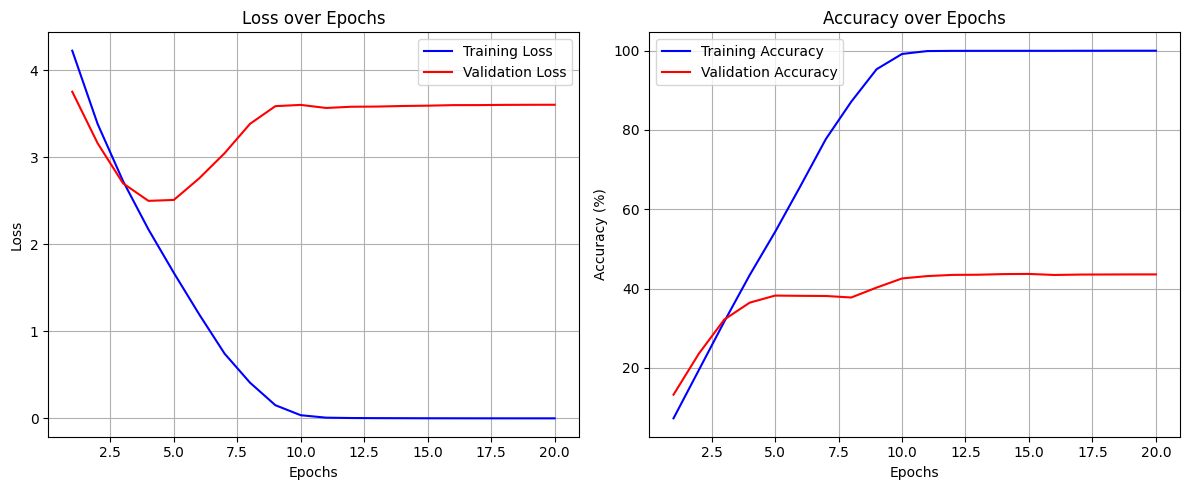

In [3]:
# Run the baseline
if __name__ == "__main__":
    run_centralized_baseline()